## Зависимости

In [1]:
import time
import warnings

warnings.simplefilter("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split

## Константы

In [2]:
PATH_TO_DATA: str = "ml-latest/ratings.csv"
TEST_SIZE: float = 0.2

EMBEDDING_DIM: int = 128

DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE: int = 8196
LEARNING_RATE: float = 1e-2

NUM_EPOCHS: int = 5

## Подготовка данных

Будем использовать таблицу `ratings.csv`. Для простоты будем считать, что если пользователь не оценивал фильм, то рейтинг будет равен 0. Также необходимо переобозначить идентификаторы фильмов и пользователей, т.к. некоторые из них отсутствуют.

In [3]:
class MovieDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        # Fill nans with zeros
        data = dataframe.fillna(0)
        ratings = data["rating"]

        # Re-label users ids from 0 to number of unique users
        unique_users = data["userId"].unique()
        user_to_index = {old: new for new, old in enumerate(unique_users)}
        new_users = data["userId"].map(user_to_index)

        # Re-label movies ids from 0 to number of movies users
        unique_movies = data["movieId"].unique()
        movie_to_index = {old: new for new, old in enumerate(unique_movies)}
        new_movies = data["movieId"].map(movie_to_index)

        # Re-labeled dataframe
        self.x = pd.DataFrame(
            {"userId": new_users, "movieId": new_movies, "rating": ratings}
        )

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx: int) -> (np.int, np.int, np.float32):
        return (
            self.x["userId"].iloc[idx].astype(np.int),
            self.x["movieId"].iloc[idx].astype(np.int),
            self.x["rating"].iloc[idx].astype(np.float32),
        )

## Модель

Мы решаем задачу регрессии. Есть эмбеддинг фильма и эмбеддинг пользователя, по ним нужно предсказать рейтинг. В качестве функции потерь и метрики будем использовать `torch.nn.MSELoss`. Для формирования эмбеддингов будем использовать слой `torch.nn.Embedding`. Далее, путем конкатенации, объединяем эмбеддинг пользователя и эмбеддинг фильма. Затем добавляем слой `torch.nn.Dropout` для предотвращения переобучения и линейный слой `torch.nn.Linear` для решения задачи регресии. 

In [4]:
class Embedder(nn.Module):
    def __init__(self, n_users: int, n_movies: int, embedding_dim: int):
        super().__init__()

        self.n_users = n_users
        self.n_movies = n_movies

        self.emb_u = nn.Embedding(self.n_users, embedding_dim)
        self.emb_m = nn.Embedding(self.n_movies, embedding_dim)

        self.dropout = nn.Dropout(p=0.1)

        self.fc = nn.Linear(embedding_dim * 2, 1)

    def forward(
        self, users: torch.Tensor, movies: torch.Tensor
    ) -> torch.Tensor:
        x_u = self.emb_u(users)
        x_m = self.emb_m(movies)

        x = torch.cat([x_u, x_m], dim=1)
        output = self.fc(self.dropout(x))

        return output

## Обучение и валидация

In [5]:
def train(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: optim,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    num_epochs: int,
    device: str,
    plotting: bool = True,
) -> (list, list):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start = time.time()
        
        train_running_loss = 0
        val_running_loss = 0

        # Train loop
        model.train()
        for users, movies, ratings in train_dataloader:
            # Send data to device
            users, movies, ratings = (
                users.to(device),
                movies.to(device),
                ratings.to(device),
            )

            out = model(users, movies)

            # Count loss
            loss = criterion(out, ratings)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()

        # Evaluation loop
        model.eval()
        for users, movies, ratings in val_dataloader:
            # Send data to device
            users, movies, ratings = (
                users.to(device),
                movies.to(device),
                ratings.to(device),
            )

            # Don't need gradients on evaluation
            with torch.no_grad():
                out = model(users, movies)

            # Count validation loss
            loss = criterion(out, ratings)
            val_running_loss += loss.item()

        # Save losses
        epoch_train_loss = np.sqrt(train_running_loss / len(train_dataloader))
        epoch_val_loss = np.sqrt(val_running_loss / len(val_dataloader))

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # Plotting
        if plotting:
            plt.title("Loss history")
            plt.plot(train_losses, label="train")
            plt.plot(val_losses, label="validation")
            plt.xlabel("epoch")
            plt.ylabel("loss")
            plt.grid()
            plt.legend()
            plt.show()

        # Logging
        end = time.time()
        
        print(
            f"Epoch №{epoch} | "
            f"Train RMSE: {epoch_train_loss:.4f} | "
            f"Validation RMSE: {epoch_val_loss:.4f} | "
            f"Time: {end - start:.4f} seconds"
        )

        clear_output(wait=True)

    return train_losses, val_losses

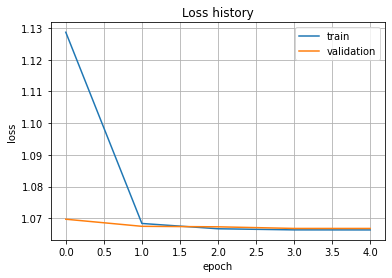

Epoch №4 | Train RMSE: 1.0663 | Validation RMSE: 1.0668 | Time: 1014.2305 seconds


In [6]:
def main() -> None:
    # Read data
    data = pd.read_csv(PATH_TO_DATA)

    # Count number of unique users and movies
    n_users = len(data["userId"].unique())
    n_movies = len(data["movieId"].unique())

    # Train-validation split
    train_data, val_data = train_test_split(
        data, test_size=TEST_SIZE, random_state=42
    )

    # Datasets and dataloaders
    train_dataset = MovieDataset(dataframe=train_data)
    train_dataloader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True
    )

    val_dataset = MovieDataset(dataframe=val_data)
    val_dataloader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False
    )

    # Model, loss function and optimizer
    model = Embedder(n_users, n_movies, embedding_dim=EMBEDDING_DIM).to(DEVICE)
    criterion = nn.MSELoss(reduction="mean")
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train & evaluate
    _, _ = train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        plotting=True,
    )


if __name__ == "__main__":
    main()